In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from IPython.display import Image, display

/home/dheeraj/.local/lib/python3.5/site-packages/tensorflow/python/framework/dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/dheeraj/.local/lib/python3.5/site-packages/tensorflow/python/framework/dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/dheeraj/.local/lib/python3.5/site-packages/tensorflow/python/framework/dtypes.py:525: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/dheeraj/.local/lib/python3.5/site-packages/tensorflow/python/framework/dtypes.py:5

In [2]:
# X and Z will have real data and generated data respetivel
X = tf.placeholder(tf.float32, shape = [None, 784])
Z = tf.placeholder(tf.float32, shape = [None, 100])

In [3]:
def show_images(images):
    images = np.reshape(images, [images.shape[0],-1])
    sqrt_n = int(np.ceil(np.sqrt(images.shape[0])))
    sqrt_img = int(np.ceil(np.sqrt(images.shape[1])))
    
    fig = plt.figure(figsize = (sqrt_n, sqrt_n))
    gs = gridspec.GridSpec(sqrt_n, sqrt_n)
    gs.update(wspace = 0.05, hspace = 0.05)
    
    for i, img in enumerate(images):
        ax  = plt.subplot(gs[i])
        plt.axis('Off')
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        plt.imshow(img.reshape([sqrt_img, sqrt_img]))
        
    return

#### Assigning the network weights before we start training seems to be a random process, right? We don’t know anything about the data, so we are not sure how to assign the weights that would work in that particular case. One good way is to assign the weights from a Gaussian distribution. Obviously this distribution would have zero mean and some finite variance. Let’s consider a linear neuron:

#### y = w1x1 + w2x2 + ... + wNxN + b
#### With each passing layer, we want the variance to remain the same. This helps us keep the signal from exploding to a high value or vanishing to zero. In other words, we need to initialize the weights in such a way that the variance remains the same for x and y. This initialization process is known as Xavier initialization. You can read the original paper here.

In [4]:
def generator(z):
    
    with tf.variable_scope("generator", reuse = tf.AUTO_REUSE):
        init = tf.contrib.layers.xavier_initializer()
        h1 = tf.layers.dense(inputs = z, units = 128, activation = tf.nn.relu, kernel_initializer = init, 
                            use_bias = True)
        
        h2 = tf.layers.dense(inputs = h1, units = 128, activation = tf.nn.relu, kernel_initializer =init,
                             use_bias = True)
        
        h3 = tf.layers.dense(inputs = h2, units = 256, activation = tf.nn.relu, kernel_initializer =init,
                             use_bias = True)
        
        out = tf.layers.dense(inputs = h3, units = 784, activation = tf.nn.tanh, kernel_initializer =init,
                             use_bias = True)
        
        return out
    
def discriminator(x):
    with tf.variable_scope("discriminator", reuse = tf.AUTO_REUSE):
        init = tf.contrib.layers.xavier_initializer()
        h1 = tf.layers.dense(inputs = x, units = 64, activation = tf.nn.relu, kernel_initializer= init, 
                             use_bias = True)
        
        h2 = tf.layers.dense(inputs = h1, units = 128, activation = tf.nn.relu, kernel_initializer= init, 
                             use_bias = True)
        
        
        h3 = tf.layers.dense(inputs = h2, units = 256, activation = tf.nn.relu, kernel_initializer= init, 
                             use_bias = True)
        
        logits  = tf.layers.dense(inputs = h3, units = 1,kernel_initializer= init,  use_bias = True)
        
        return logits
        

In [ ]:
def sample_Z(r, c):
    return np.random.uniform(-1., 1., size = [r, c])


In [ ]:
G_sample = generator(Z)
logits_real = discriminator(X)
logits_fake = discriminator(G_sample)
print(G_sample.shape, X.shape)

(?, 784) (?, 784)


In [ ]:
print(tf.ones_like(logits_real))

Tensor("ones_like:0", shape=(?, 1), dtype=float32)


In [ ]:
# now calculating the loss fucntion for both generator and discriminator

#now for D_loss_real, we have taken labels as tf.ones_like
D_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(labels = tf.ones_like(logits_real),
                                                                     logits = logits_real))

# for D_loss_fake, we have taken the labels as tf.zeros_like, because it needs to reduce the output 
#generated by the generator
D_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(labels = tf.zeros_like(logits_fake),
                                                                     logits = logits_fake))

D_loss = D_loss_real + D_loss_fake

#For G_loss, we have taken labels  as tf.ones_like, this is because the generator needs to maximize itself
#with respect to the discriminator
G_loss= tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(labels = tf.ones_like(logits_fake),
                                                                     logits = logits_fake))

In [ ]:
#Actual loss code for the equations but above is the better version of it

D_real = tf.nn.sigmoid(logits_real)
D_fake = tf.nn.sigmoid(logits_fake)

D_loss = -tf.reduce_mean(tf.log(D_real) + tf.log(1. - D_fake))

G_loss = -tf.reduce_mean(tf.log(D_fake))


In [ ]:
D_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, 'discriminator')
G_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, 'generator')


In [ ]:
D_solver = tf.train.AdamOptimizer(learning_rate = 1e-3, beta1 = 0.5).minimize(D_loss, var_list = D_vars)
G_solver = tf.train.AdamOptimizer(learning_rate = 1e-3, beta1 = 0.5).minimize(G_loss, var_list = G_vars)


In [ ]:
sess = tf.Session()
sess.run(tf.global_variables_initializer())


In [ ]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("MNIST_data/", one_hot = True)


Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data/train-images-idx3-ubyte.gz
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Instructions for updating:
Please use tf.one_hot on tensors.
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.


Initial generated images
[[-0.07147456  0.16293749 -0.11681082 ...  0.02182819  0.02542585
  -0.01719183]
 [-0.15182695  0.10850564 -0.10140233 ...  0.08370474  0.09237065
   0.06073118]
 [-0.05338646  0.09097564 -0.02872927 ...  0.05591038  0.09736352
   0.05345441]
 ...
 [-0.0609074   0.23833342 -0.11873887 ...  0.03203001 -0.02216855
  -0.10475086]
 [-0.17736217 -0.00306893 -0.10999341 ...  0.12988207  0.02638957
  -0.00595805]
 [-0.0667194   0.00939209  0.11305749 ...  0.0583918   0.01243212
  -0.0175563 ]]


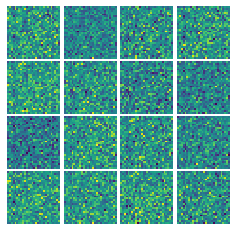

In [ ]:
print("Initial generated images")
samples = sess.run(G_sample,feed_dict={Z: sample_Z(128, 100)})
print(samples)
fig = show_images(samples[:16])
plt.show()
print()

## now training the model

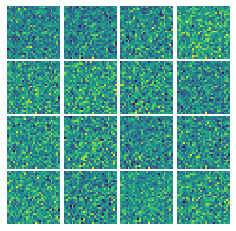


iter : 0
D loss : 1.384
G loss : 0.7394



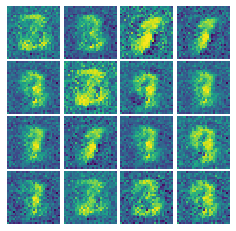


iter : 1000
D loss : 0.9885
G loss : 1.626



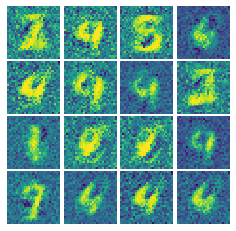


iter : 2000
D loss : 1.17
G loss : 1.197



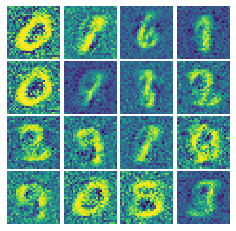


iter : 3000
D loss : 1.273
G loss : 1.033



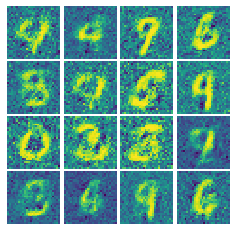


iter : 4000
D loss : 1.307
G loss : 0.9671



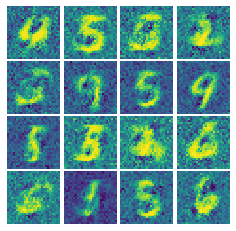


iter : 5000
D loss : 1.293
G loss : 1.137



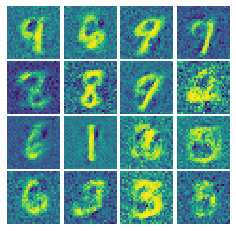


iter : 6000
D loss : 1.278
G loss : 1.006



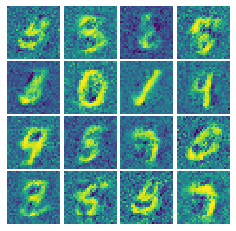


iter : 7000
D loss : 1.257
G loss : 0.9884



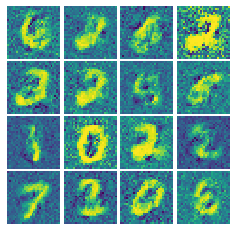


iter : 8000
D loss : 1.315
G loss : 0.8789



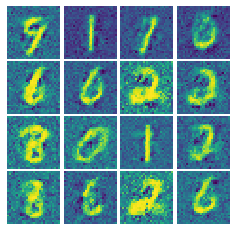


iter : 9000
D loss : 1.286
G loss : 0.9373



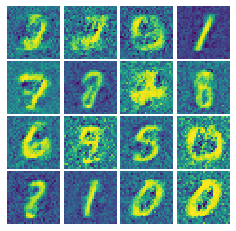


iter : 10000
D loss : 1.144
G loss : 1.056



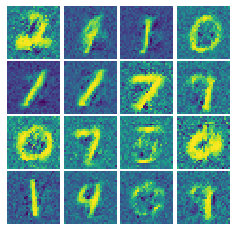


iter : 11000
D loss : 1.191
G loss : 0.9879



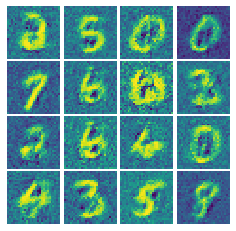


iter : 12000
D loss : 1.076
G loss : 1.295



In [ ]:
for it in range(50000):
    
    # this loop is for shoing the generated images over iterations
    if(it%1000 == 0):
        samples = sess.run(G_sample, feed_dict = {Z: sample_Z(128, 100)})
        fig = show_images(samples[:16])
        plt.show()
        print()
        
        # batch size has been defines to 128
    x, _ = mnist.train.next_batch(128)
    _, D_loss_curr = sess.run([D_solver, D_loss], feed_dict = {X: x, Z : sample_Z(128, 100)})
    _, G_loss_curr = sess.run([G_solver, G_loss], feed_dict = {Z: sample_Z(128, 100)})

    if(it%1000 == 0):
        print("iter : {}".format(it))
        print("D loss : {:.4}".format(D_loss_curr))
        print("G loss : {:.4}".format(G_loss_curr))
        print()

        
    